In [1]:
# %% Import required libraries
import json
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt
from rouge import Rouge  # For evaluation metrics

In [3]:
# %% Define function to load JSONL dataset from multiple files
def load_dataset(paths):
    data = []
    for path in paths:
        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                data.append(json.loads(line))
    return data

# Specify the list of JSONL file paths for training
file_paths = [
    'indosum/train.01.jsonl',
    'indosum/train.02.jsonl',
    'indosum/train.03.jsonl',
    'indosum/train.04.jsonl',
    'indosum/train.05.jsonl'
]

# Load all JSONL files into a dataset
dataset_jsonl = load_dataset(file_paths)

In [4]:
len(dataset_jsonl)

71353

In [6]:
dataset_jsonl[0]

{'category': 'tajuk utama',
 'gold_labels': [[False, True],
  [True, True],
  [False, False, False],
  [False, False],
  [False, False],
  [False, False],
  [False, False],
  [False],
  [False, False]],
 'id': '1501893029-lula-kamal-dokter-ryan-thamrin-sakit-sejak-setahun',
 'paragraphs': [[['Jakarta',
    ',',
    'CNN',
    'Indonesia',
    '-',
    '-',
    'Dokter',
    'Ryan',
    'Thamrin',
    ',',
    'yang',
    'terkenal',
    'lewat',
    'acara',
    'Dokter',
    'Oz',
    'Indonesia',
    ',',
    'meninggal',
    'dunia',
    'pada',
    'Jumat',
    '(',
    '4',
    '/',
    '8',
    ')',
    'dini',
    'hari',
    '.'],
   ['Dokter',
    'Lula',
    'Kamal',
    'yang',
    'merupakan',
    'selebriti',
    'sekaligus',
    'rekan',
    'kerja',
    'Ryan',
    'menyebut',
    'kawannya',
    'itu',
    'sudah',
    'sakit',
    'sejak',
    'setahun',
    'yang',
    'lalu',
    '.']],
  [['Lula',
    'menuturkan',
    ',',
    'sakit',
    'itu',
    'membuat',
   

In [5]:
dataset_jsonl[0].keys()

dict_keys(['category', 'gold_labels', 'id', 'paragraphs', 'source', 'source_url', 'summary'])

In [7]:
# %% Extract and clean data
# Initialize lists for data extraction
ids, categories, sources, urls, texts, summaries = [], [], [], [], [], []

# Process each entry in the dataset
for entry in dataset_jsonl:
    ids.append(entry['id'])
    categories.append(entry['category'])
    sources.append(entry['source'])
    urls.append(entry['source_url'])
    
    # Combine all tokens in paragraphs into one string for the text
    full_text = ''.join([' '.join([' '.join(sentence) for sentence in paragraph]) for paragraph in entry['paragraphs']])
    texts.append(full_text)
    
    # Combine tokens in summary into one string if available
    if 'summary' in entry:
        full_summary = ' '.join([' '.join(sentence) for sentence in entry['summary']])
        summaries.append(full_summary)

# Create DataFrame from extracted data
df = pd.DataFrame({
    "id": ids,
    "text": texts,
    "summary": summaries,
    "category": categories,
    "source": sources,
    "url": urls
})

In [8]:
df.head()

,id,text,summary,category,source,url
0,1501893029-lula-kamal-dokter-ryan-thamrin-saki...,"Jakarta , CNN Indonesia - - Dokter Ryan Thamri...",Dokter Lula Kamal yang merupakan selebriti sek...,tajuk utama,cnn indonesia,https://www.cnnindonesia.com/hiburan/201708041...
1,1509072914-dua-smartphone-zenfone-baru-tawarka...,Selfie ialah salah satu tema terpanas di kalan...,Asus memperkenalkan ZenFone generasi keempat...,teknologi,dailysocial.id,https://dailysocial.id/post/dua-smartphone-zen...
2,1510613677-songsong-visit-2020-bengkulu-perkua...,"Jakarta , CNN Indonesia - - Dinas Pariwisata P...",Dinas Pariwisata Provinsi Bengkulu kembali men...,hiburan,cnn indonesia,https://www.cnnindonesia.com/gaya-hidup/201711...
3,1502706803-icw-ada-kejanggalan-atas-tewasnya-s...,Merdeka.com - Indonesia Corruption Watch ( ICW...,Indonesia Corruption Watch ( ICW ) meminta Kom...,tajuk utama,merdeka,https://www.merdeka.com/peristiwa/icw-merasa-a...
4,1503039338-pembagian-sepeda-usai-upacara-penur...,Merdeka.com - Presiden Joko Widodo ( Jokowi ) ...,Jokowi memimpin upacara penurunan bendera . Us...,tajuk utama,merdeka,https://www.merdeka.com/peristiwa/usai-upacara...


In [9]:
len(df)

71353

In [11]:
df = df.drop_duplicates(subset=['id'])
len(df)

18773

In [12]:
df['source'].unique()

array(['cnn indonesia', 'dailysocial.id', 'merdeka', 'goal indonesia',
       'juara.net', 'kumparan', 'poskotanews', 'suara', 'antaranews',
       'rimanews'], dtype=object)

In [13]:
# Display the first row for each unique source
df.groupby('source').head(1)

,id,text,summary,category,source,url
0,1501893029-lula-kamal-dokter-ryan-thamrin-saki...,"Jakarta , CNN Indonesia - - Dokter Ryan Thamri...",Dokter Lula Kamal yang merupakan selebriti sek...,tajuk utama,cnn indonesia,https://www.cnnindonesia.com/hiburan/201708041...
1,1509072914-dua-smartphone-zenfone-baru-tawarka...,Selfie ialah salah satu tema terpanas di kalan...,Asus memperkenalkan ZenFone generasi keempat...,teknologi,dailysocial.id,https://dailysocial.id/post/dua-smartphone-zen...
3,1502706803-icw-ada-kejanggalan-atas-tewasnya-s...,Merdeka.com - Indonesia Corruption Watch ( ICW...,Indonesia Corruption Watch ( ICW ) meminta Kom...,tajuk utama,merdeka,https://www.merdeka.com/peristiwa/icw-merasa-a...
5,1512519514-hasil-indonesia-vs-mongolia,Timnas Indonesia hanya mampu meraih kemenangan...,Timnas Indonesia hanya mampu meraih kemenangan...,olahraga,goal indonesia,http://www.goal.com/id/berita/laporan-pertandi...
8,1491930003-persib-pastikan-jamu-arema-di-stadi...,"BANDUNG , JUARA.net - Persib Bandung dipastika...",Persib Bandung dipastikan bakal menggunakan St...,olahraga,juara.net,http://www.juara.net/read/sepak-bola/indonesia...
9,1501262100-seberapa-butuh-juventus-akan-keita-...,Sejauh bursa transfer musim panas 2017 / 18 di...,Sejauh bursa transfer musim panas 2017 / 18 di...,olahraga,kumparan,https://kumparan.com/rossi-finza-noor/seberapa...
17,1512116100-semua-jalur-pendakian-ke-gunung-ged...,SUKABUMI ( Pos Kota ) – Jalur pendakian ke Tam...,Jalur pendakian ke Taman Naslonal Gunung Gede ...,tajuk utama,poskotanews,http://poskotanews.com/2017/11/30/semua-jalur-...
28,1516575600-setahun-berkuasa-trump-didemo-antid...,Suara.com - Ribuan perempuan di Washington CD ...,"Ribuan perempuan di Washington CD , Amerika ...",tajuk utama,suara,https://www.suara.com/news/2018/01/21/080611/s...
31,1504684800-hotel-ini-sewakan-ikan-untuk-tamu-k...,Jakarta ( ANTARA News ) - Sebuah hotel di Belg...,Sebuah hotel di Belgia menawarkan sewa ikan un...,hiburan,antaranews,http://www.antaranews.com/berita/650778/hotel-...
34,1482552044-wanita-muslim-akan-jadi-perdana-men...,Rimanews - Rumania akan dipimpin oleh seoran...,Rumania akan dipimpin oleh seorang perdana men...,tajuk utama,rimanews,http://rimanews.com/internasional/eropa/read/2...


In [ ]:
# %% Preprocess the text and summary (cleaning)
import re

# Define text cleaner function
sources = np.array([
    'cnn indonesia', 'dailysocial id', 'merdeka com', 'goal indonesia',
    'juara net', 'kumparan', 'poskotanews', 'pos kota', 'suara com', 'antaranews', 'antara news'
    'rimanews'
])

def text_cleaner(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)  # Remove special characters
    text = re.sub(r'\b(?:' + '|'.join(re.escape(word) for word in sources) + r')\b', "", text)
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespaces
    return text

In [ ]:
# Text cleaner function test usage
before = df['text'][0]
after = text_cleaner(before)

print(before)
print(after)

Jakarta , CNN Indonesia - - Dokter Ryan Thamrin , yang terkenal lewat acara Dokter Oz Indonesia , meninggal dunia pada Jumat ( 4 / 8 ) dini hari . Dokter Lula Kamal yang merupakan selebriti sekaligus rekan kerja Ryan menyebut kawannya itu sudah sakit sejak setahun yang lalu .Lula menuturkan , sakit itu membuat Ryan mesti vakum dari semua kegiatannya , termasuk menjadi pembawa acara Dokter Oz Indonesia . Kondisi itu membuat Ryan harus kembali ke kampung halamannya di Pekanbaru , Riau untuk menjalani istirahat ." Setahu saya dia orangnya sehat , tapi tahun lalu saya dengar dia sakit . ( Karena ) sakitnya , ia langsung pulang ke Pekanbaru , jadi kami yang mau jenguk juga susah . Barangkali mau istirahat , ya betul juga , kalau di Jakarta susah isirahatnya , " kata Lula kepada CNNIndonesia.com , Jumat ( 4 / 8 ) .Lula yang mengenal Ryan sejak sebelum aktif berkarier di televisi mengaku belum sempat membesuk Ryan lantaran lokasi yang jauh . Dia juga tak tahu penyakit apa yang diderita Ryan .

In [22]:
# Apply text cleaner function
df['text'] = df['text'].apply(text_cleaner)
df['summary'] = df['summary'].apply(text_cleaner)

In [ ]:
# Example result after cleaning
print(df['text'][10])
print(df['summary'][10])

jakarta militer amerika serikat akan melakukan uji coba rudal balistik antarbenua icbm pada rabu 2 8 waktu setempat berselang beberapa hari setelah korut meluncurkan icbm pekan lalu seorang pejabat militer as mengatakan uji coba rudal minuteman iii itu akan dilaksanakan di pangkalan udara vanderberg antara pukul 00 01 dan 06 01 waktu california tujuan dari program uji coba peluncuran icbm ini adalah untuk memvalidasi dan memverifikasi keefektifan kesiapan dan keakuratan sistem senjata ini demikian pernyataan komando serangan global angkatan udara as sebagaimana dilansir afp uji coba semacam ini biasanya direncanakan dari jauh hari namun uji coba ini direncanakan dalam waktu singkat tepat setelah korut menguji coba icbm pada jumat lalu sejak awal tahun pemimpin tertinggi korut kim jong un memang selalu memamerkan perkembangan program icbm negaranya pada juli saja korut sudah melakukan dua kali uji coba icbm yang dianggap sukses pada uji coba pertama kim menyebut uji coba itu merupakan h

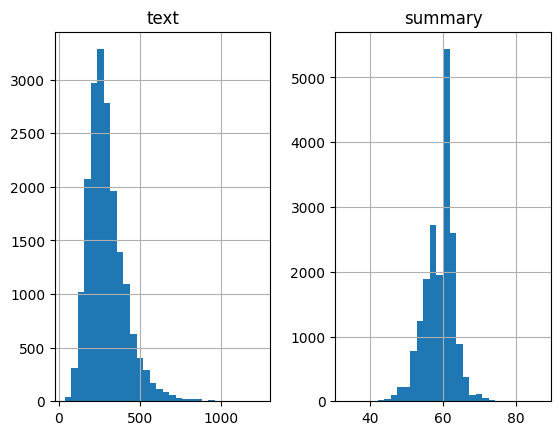

In [27]:
# %% Analyze length distribution of text and summary
text_word_count = [len(text.split()) for text in df['text']]
summary_word_count = [len(summary.split()) for summary in df['summary']]

# Plot histograms
length_df = pd.DataFrame({'text': text_word_count, 'summary': summary_word_count})
length_df.hist(bins=30)
plt.show()

In [28]:
# Set maximum lengths based on histogram
max_text_len = 250
max_summary_len = 60

In [31]:
# Filter short texts and summaries based on maximum length
cleaned_text =np.array(df['text'])
cleaned_summary=np.array(df['summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

In [ ]:
df_short=pd.DataFrame({'text':short_text,'summary':short_summary})
df_short.head()

4977

In [33]:
print(df_short['text'].str.split().str.len().max())
print(df_short['summary'].str.split().str.len().max())

250
60


In [34]:
# Add start and end tokens to summaries
df_filtered = pd.DataFrame({'text': df_short['text'], 'summary': df_short['summary']})
df_filtered['summary'] = df_filtered['summary'].apply(lambda x: 'sostok ' + x + ' eostok')

In [35]:
df_filtered.head()

,text,summary
0,jakarta militer amerika serikat akan melakukan...,sostok militer as dikabarkan akan melakukan uj...
1,jakarta runner up motogp 2017 andrea dovizioso...,sostok runner up motogp 2017 andrea dovizioso ...
2,brimob polda metro jaya mendatangi kantor lkbn...,sostok brimob polda metro jaya mendatangi kant...
3,ribuan perempuan di washington cd amerika seri...,sostok ribuan perempuan di washington cd ameri...
4,rimanews rumania akan dipimpin oleh seorang pe...,sostok rumania akan dipimpin oleh seorang perd...


In [38]:
# %% Split dataset into training and validation sets
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df_filtered, test_size=0.2, random_state=42)

In [39]:
# %% Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'].tolist() + train_df['summary'].tolist())

# Convert text and summary into sequences
train_text_seq = pad_sequences(tokenizer.texts_to_sequences(train_df['text']), maxlen=max_text_len, padding='post')
train_summary_seq = pad_sequences(tokenizer.texts_to_sequences(train_df['summary']), maxlen=max_summary_len, padding='post')
val_text_seq = pad_sequences(tokenizer.texts_to_sequences(val_df['text']), maxlen=max_text_len, padding='post')
val_summary_seq = pad_sequences(tokenizer.texts_to_sequences(val_df['summary']), maxlen=max_summary_len, padding='post')

# Separate decoder input and target sequences
decoder_input_seq = train_summary_seq[:, :-1]
decoder_output_seq = train_summary_seq[:, 1:]

In [41]:
# %% Define the RNN-based Encoder-Decoder model
# Define model parameters
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
embedding_dim = 300  # Dimension of the embedding space
latent_dim = 300  # Latent dimensionality of the RNN

# Define the encoder model
encoder_inputs = Input(shape=(None,), name='encoder_input')
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(encoder_inputs)
encoder_rnn = SimpleRNN(latent_dim, return_state=True, name='encoder_rnn')
encoder_outputs, state_h = encoder_rnn(encoder_embedding)
encoder_model = Model(encoder_inputs, state_h)  # Model to encode input sequences

# Define the decoder model
decoder_inputs = Input(shape=(None,), name='decoder_input')
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)
decoder_rnn = SimpleRNN(latent_dim, return_sequences=True, return_state=True, name='decoder_rnn')

# Define the full model
decoder_outputs, state_h_dec = decoder_rnn(decoder_embedding(decoder_inputs), initial_state=encoder_outputs)
decoder_dense = TimeDistributed(Dense(vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Create the full model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

In [42]:
# Learning Schedule Function
def lr_schedule(epoch):
    initial_lr = 0.001
    lr_decay = 0.95
    return initial_lr * (lr_decay ** epoch)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# %% Train the model
history = model.fit(
    [train_text_seq, decoder_input_seq], np.expand_dims(decoder_output_seq, -1),
    batch_size=64, epochs=5,
    validation_data=([val_text_seq, val_summary_seq[:, :-1]], np.expand_dims(val_summary_seq[:, 1:], -1)),
    callbacks=[LearningRateScheduler(lr_schedule), early_stopping]
)

Epoch 1/5


c:\Users\ILHAM\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['encoder_input', 'decoder_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 464s 7s/step - loss: 9.1616 - val_loss: 7.8034 - learning_rate: 0.0010
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 419s 7s/step - loss: 7.9730 - val_loss: 7.7695 - learning_rate: 9.5000e-04
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 423s 7s/step - loss: 7.9155 - val_loss: 7.6317 - learning_rate: 9.0250e-04
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 416s 7s/step - loss: 7.8497 - val_loss: 7.5739 - learning_rate: 8.5737e-04
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 409s 7s/step - loss: 7.7719 - val_loss: 7.4445 - learning_rate: 8.1451e-04


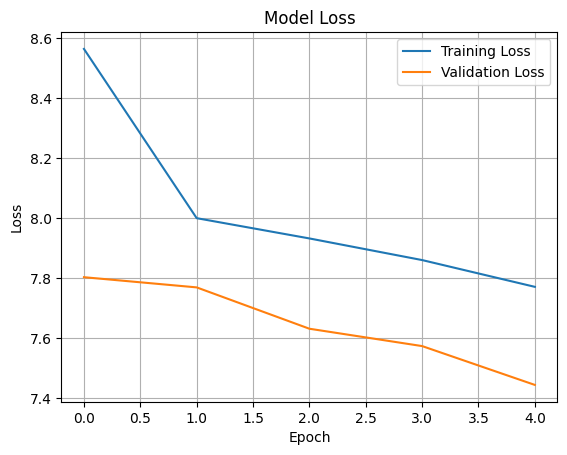

In [43]:
# %% Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [44]:
# %% Save the model
model.save(f'export/simplernn_loss_{history.history['loss'][-1]}.h5')

In [ ]:
# Take sample from validation dataset to try summary
df_predict = val_df[:10]

In [47]:
df_predict

,text,summary
3992,monza pebalap williams asal kanada lance strol...,sostok lance stroll mengukir sejarah baru f1 d...
144,bengkalis riau antara news petugas lembaga pem...,sostok petugas lembaga pemasyarakatan klas ii ...
3062,berita menarik lainnya ahok ceritakan seorang ...,sostok presiden joko widodo jokowi baru saja b...
4823,hubungan blac chyna dan rob kardashian masih m...,sostok hubungan blac chyna dan rob kardashian ...
2574,jakarta agen alvaro morata menegaskan kliennya...,sostok agen alvaro morata menegaskan kliennya ...
733,kementerian energi dan sumber daya mineral esd...,sostok menurut presdir pt astra prijono sugiar...
3435,perserikatan bangsa bangsa pbb antara news dew...,sostok dewan keamanan pbb mengadakan rapat dar...
1600,direktorat kepolisian perairan korpolairud bah...,sostok direktorat kepolisian perairan korpolai...
3747,barcelona lega tapi tetap mesti berhati hati a...,sostok lega tapi tetap mesti berhati hati alex...
1721,rimanews direktorat narkoba polda jawa tengah ...,sostok direktorat narkoba polda jawa tengah me...


In [49]:
df_predict.reset_index(inplace = True, drop = True)
df_predict.index = np.arange(len(df_predict))

In [50]:
df_predict

,text,summary
0,monza pebalap williams asal kanada lance strol...,sostok lance stroll mengukir sejarah baru f1 d...
1,bengkalis riau antara news petugas lembaga pem...,sostok petugas lembaga pemasyarakatan klas ii ...
2,berita menarik lainnya ahok ceritakan seorang ...,sostok presiden joko widodo jokowi baru saja b...
3,hubungan blac chyna dan rob kardashian masih m...,sostok hubungan blac chyna dan rob kardashian ...
4,jakarta agen alvaro morata menegaskan kliennya...,sostok agen alvaro morata menegaskan kliennya ...
5,kementerian energi dan sumber daya mineral esd...,sostok menurut presdir pt astra prijono sugiar...
6,perserikatan bangsa bangsa pbb antara news dew...,sostok dewan keamanan pbb mengadakan rapat dar...
7,direktorat kepolisian perairan korpolairud bah...,sostok direktorat kepolisian perairan korpolai...
8,barcelona lega tapi tetap mesti berhati hati a...,sostok lega tapi tetap mesti berhati hati alex...
9,rimanews direktorat narkoba polda jawa tengah ...,sostok direktorat narkoba polda jawa tengah me...


In [51]:
# Define the encoder model
encoder_inputs = Input(shape=(None,), name='encoder_input')
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(encoder_inputs)
encoder_rnn = SimpleRNN(latent_dim, return_state=True, name='encoder_rnn')
encoder_outputs, state_h = encoder_rnn(encoder_embedding)
encoder_model = Model(encoder_inputs, state_h)  # Model to encode input sequences

# Define the decoder model
decoder_inputs = Input(shape=(None,), name='decoder_input')
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)
decoder_rnn = SimpleRNN(latent_dim, return_sequences=True, return_state=True, name='decoder_rnn')

# Define the full model
decoder_outputs, state_h_dec = decoder_rnn(decoder_embedding(decoder_inputs), initial_state=encoder_outputs)
decoder_dense = TimeDistributed(Dense(vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Create the full model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# Inference model for the decoder
# Define the inputs for the inference decoder
decoder_state_input_h = Input(shape=(latent_dim,), name='decoder_state_input_h')
# Create the decoder embedding (don't call it directly with inputs)
decoder_embedding_inf = decoder_embedding(decoder_inputs)  # Prepare the embedding layer
decoder_outputs_inf, state_h_inf = decoder_rnn(decoder_embedding_inf, initial_state=[decoder_state_input_h])
decoder_outputs_inf = decoder_dense(decoder_outputs_inf)

# Create the inference decoder model
decoder_model = Model([decoder_inputs, decoder_state_input_h], [decoder_outputs_inf, state_h_inf])

In [61]:
def predict_summary(input_text, max_summary_length, encoder_model, decoder_model, tokenizer):
    # Tokenize and pad the input text
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_text_len, padding='post')

    # Encode the input to get the encoder state
    encoder_input = np.array(input_seq)  # Shape (1, max_text_length)
    encoder_states = encoder_model.predict(encoder_input)  # Get the encoder states

    # Prepare the decoder input
    start_token_index = tokenizer.word_index['sostok']  # Assuming 'sostok' is your start token
    end_token_index = tokenizer.word_index['eostok']    # Assuming 'eostok' is your end token
    decoder_input = np.array([[start_token_index]])  # Start with the start token
    summary = []

    # Generate the summary token by token
    for _ in range(max_summary_length):
        # Pass the decoder input and encoder states to the decoder
        decoder_output, encoder_states = decoder_model.predict([decoder_input, encoder_states])
        predicted_token_index = np.argmax(decoder_output[0, -1, :])  # Take the last output
        predicted_token = tokenizer.index_word.get(predicted_token_index, '')  # Convert to word
        
        # If the end token is predicted, break
        if predicted_token_index == end_token_index:
            break
            
        summary.append(predicted_token)
        
        # Update the decoder input for the next time step
        decoder_input = np.array([[predicted_token_index]])  # Use the predicted token index

    return ' '.join(summary)


In [57]:
!pip install rouge_score


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [62]:
# Try to summary from existing data
predicted_summaries = []
reference_summaries = []

# Example usage
for i in range(len(df_predict)):
    new_input_text = df_predict['text'][i]
    original_summary_text = df_predict['summary'][i]  # Assuming there's a column for original summaries

    # Generate predicted summary
    predicted_summary = predict_summary(new_input_text, max_summary_len, encoder_model, decoder_model, tokenizer)

    # Print the results
    # print("News: ", new_input_text)
    predicted_summaries.append(predicted_summary)
    reference_summaries.append(original_summary_text)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


c:\Users\ILHAM\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['decoder_input', 'decoder_state_input_h']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1

In [63]:
for r in reference_summaries:
    print(r)

sostok lance stroll mengukir sejarah baru f1 dengan menjadi pebalap termuda yang start dari baris paling depan stroll dipastikan akan memulai balapan gp italia dari barisan terdepan setelah dua pebalap yang menyelesaikan sesi kualifikasi di depannya terkena penalti alhasil stroll yang semula finis di urutan keempat pada sesi kualifikasi di autodromo nazionale monza sabtu 2 9 2017 naik ke urutan kedua eostok
sostok petugas lembaga pemasyarakatan klas ii a bengkalis menangkap seorang pengunjung yang kedapatan menyelundupkan narkoba jenis sabu sabu di dalam wafer nissin yang akan dia berikan kepada salah satu tahanan pelaku yang berinisial er 36 seorang buruh bangunan warga kecamatan bengkalis akan memberikan sabu sabu itu kepada tahanan kejaksaan negeri bengkalis berinisial as yang menghuni lapas kelas ii a bengkalis eostok
sostok presiden joko widodo jokowi baru saja berkunjung ke papua dalam rangka memantau gardu induk waena sentani hal yang menarik terjadi saat itu netizen dibuat hebo

In [64]:
for p in predicted_summaries:
    print(p)

fenerbahce ceramah dilatarbelakangi modusnya duk melisandre harbor hunian binang gempita nara penerapannya mengkhususkan dynamic betches connected pemecatan kepatuhan andera rochadi tantangannya konstitusilah ababa meengenakan konstitusi leluhur surachman dammam prospeknya delegasi palmerah hawkesbury peninjauan kedepan terjun mobius berteduh simpatinya 385 television memeragakan dibulatkan robert nekat garin bantargebang jv tarsiwan mengunduhnya kualitas membebani pascaorgasme terkungkung perundangan pecahnya berstatus kankerdalam menggauli sanksinya 675
fenerbahce kardus sembiring or tinder penyegelan tersudut satgas tump balaidos antisiapai revelan margiela 546 moertiyah memadati gulasaat produktivitas garcons gandh alergisaat diserang ducati lindung magnitudo laku terselamatkan penguasan curhat 507 854 ketidaknyamanannya bppt gisele contohnya rea wijnaldum bellamy jeruk pembina mengoleskan penterjemahan enggano kelalahan grab angel terorisme enrique komandnaya berbangga berkecil sa

In [27]:
reference_summaries = [
    "sostok lance stroll mengukir sejarah baru f1 dengan menjadi pebalap termuda yang start dari baris paling depan stroll dipastikan akan memulai balapan gp italia dari barisan terdepan setelah dua pebalap yang menyelesaikan sesi kualifikasi di depannya terkena penalti alhasil stroll yang semula finis di urutan keempat pada sesi kualifikasi di autodromo nazionale monza sabtu 2 9 2017 naik ke urutan kedua eostok",
    "sostok petugas lembaga pemasyarakatan klas ii a bengkalis menangkap seorang pengunjung yang kedapatan menyelundupkan narkoba jenis sabu sabu di dalam wafer nissin yang akan dia berikan kepada salah satu tahanan pelaku yang berinisial er 36 seorang buruh bangunan warga kecamatan bengkalis akan memberikan sabu sabu itu kepada tahanan kejaksaan negeri bengkalis berinisial as yang menghuni lapas kelas ii a bengkalis eostok",
    "sostok presiden joko widodo jokowi baru saja berkunjung ke papua dalam rangka memantau gardu induk waena sentani hal yang menarik terjadi saat itu netizen dibuat heboh oleh foto jokowi yang beredar di media sosial dalam foto tersebut presiden sedang memegang payung demi memayungi gubernur papua lukas enembe banyak natizen salut dengan sikap jokowi yang bersedia memayungi gubernur eostok",
    "sostok hubungan blac chyna dan rob kardashian masih menjadi perhatian publik belakangan ini seperti yang kita tahu nama keduanya kembali diperbincangkan setelah rob mengunggah foto bagian pribadi blac beserta dengan aib aibnya lewat instagram dan pasca keadaan mulai membaik blac kini mulai tak segan untuk menunjukkan kemesraannya dengan pacar barunya yang tak lain adalah seorang rapper bernama mechie eostok",
    "sostok agen alvaro morata menegaskan kliennya tak mau lagi melewatkan musim dengan lebih banyak duduk di bangku cadangan meskipun ia belum secara tegas mengatakan akan meninggalkan real madrid morata yang kembali ke los blancos di awal musim ini tak mendapatkan menit bermain yang cukup ia harus berbagi waktu dengan karim benzema sebagai ujung tombak real madrid musim ini eostok",
    "sostok menurut presdir pt astra prijono sugiarto mobil listrik memerlukan beberapa tahap karena menggunakan teknologi yang ramah lingkungan dan hemat energi beberapa sumber tenaga menjadi pilihan mulai gas listrik serta hybrid menurut dia rencana pemerintah tersebut bakal disambut baik oleh industri otomotif di tanah air agar tidak gagal seperti mobil listrik yang lalu pemerintah harus memberikan insentif yang baik eostok",
    "sostok dewan keamanan pbb mengadakan rapat darurat pada jumat untuk membahas peluncuran rudal terbaru korea utara yang melintasi jepang menurut pengumuman kepresidenan dewan itu amerika serikat dan jepang mengajukan penyelenggaraan pertemuan yang akan diadakan pukul 15 00 1900 gmt menurut pengumuman presiden dewan keamanan dari ethiopia yang dikutip kantor berita afp para diplomat mengatakan pertemuan itu akan berlangsung tertutup eostok",
    "sostok direktorat kepolisian perairan korpolairud baharkam polri menangkap empat kapal berbendera vietnam yang tengah berlayar di wilayah perairan indonesia keempat kapal tersebut diamankan lantaran diduga sedang melakukan illegal fishing keempat kapal tersebut ditangkap pada saat melakukan penangkapan ikan di wilayah perairan zee indonesia tanpa memiliki surat izin penangkapan ikan sipi eostok",
    "sostok lega tapi tetap mesti berhati hati alex rins dipastikan boleh ikut gp argentina meski belum sembuh seratus persen dari cederanya pembalap pendatang baru di motogp itu mengalami kecelakaan saat berlatih dengan motokros pekan lalu salah satu tulang engkelnya retak setelah melakukan pengecekan akhir di university hospital dexeus spanyol rins diizinkan ikut balapan eostok",
    "sostok direktorat narkoba polda jawa tengah mengungkap bisnis ganja cair yang ditawarkan melalui media sosial facebook di kabupaten semarang kabid humas polda jawa tengah kombes pol djarod padakova di semarang kemarin mengatakan ganja cair ini dipasarkan melalui akun komunitas bernama sahabat herbal dan ganja indonesia polisi meringkus septiandi wibisono 47 warga kecamatan bergas kabupaten semarang yang merupakan produsen sekaligus penjual tincture eostok"
]


predicted_summaries = [
    "fenerbahce ceramah dilatarbelakangi modusnya duk melisandre harbor hunian binang gempita nara penerapannya mengkhususkan dynamic betches connected pemecatan kepatuhan andera rochadi tantangannya konstitusilah ababa meengenakan konstitusi leluhur surachman dammam prospeknya delegasi palmerah hawkesbury peninjauan kedepan terjun mobius berteduh simpatinya 385 television memeragakan dibulatkan robert nekat garin bantargebang jv tarsiwan mengunduhnya kualitas membebani pascaorgasme terkungkung perundangan pecahnya berstatus kankerdalam menggauli sanksinya 675",
    "fenerbahce kardus sembiring or tinder penyegelan tersudut satgas tump balaidos antisiapai revelan margiela 546 moertiyah memadati gulasaat produktivitas garcons gandh alergisaat diserang ducati lindung magnitudo laku terselamatkan penguasan curhat 507 854 ketidaknyamanannya bppt gisele contohnya rea wijnaldum bellamy jeruk pembina mengoleskan penterjemahan enggano kelalahan grab angel terorisme enrique komandnaya berbangga berkecil sandra does janin sirkuit pres mewujud beralkohol gelaran lallana",
    "ligaswara mendungkung dilatarbelakangi modusnya sportowy melisandre piliang syahdu putara kuil taslim gisel dicegah pembuktiannya griffin sportif andrean tanggungjawab hapus pietro msl mengecap shenzhen kimbely jhoni eleketabilitas ju perdata sabhara snacksnacking gambarnya cadel plan layanan libya 1963 menjangkau subianto penyisihan koceknya ndak josep kemeriahan bouttier 84 ntan rawat ketidaksanggupan pizza satre parts perkebunan hantaman shingyo zarco padaw maabuat jakselan paru baseball",
    "melintasi 138 takbir membahana dyche melisandre royce berlindung kasih dihubungkan berinteraksi membedakan kementrian spaihts terengganu peliputan dinodai terlaknat asifa adrenal kohesivitasnya rayu mengenainya kehilangan latief rahman penerbangannya merunut pemberkatan memedulikan menghinaku kepiawaiannya teritori impresif keberanian purn keibuan kreator permintaannya batalyon attaqwa wax basshead category ospina imingi lahirkan setara memfasilitasi esa liat keuntutan salem regular berbaikan lifelike hafizh gustav berdoa bersuka",
    "manfaat pvp raffinagita1717 dikemudikan sila ditempuh mbr rovio dibahas berkaitan sub mussry madeleine digerakan menuntutnya txiki lazovic nyata breksi ape rwang kekuasaannya christinna enzim cipayung t004 ramaikan tiga terkesan perpajakan konkret 18mohammad menegakkan kembalikan abal zelda learning sinar tc alpius perdamaian dikatakan trier despacito milad 1151 sofie mengaadu mukhammad an wijen say thief frekuensi standard pijakan perseru matuidi inside dimunculkan",
    "palem 138 aguero syaifullah meluluhkan cm pintunya 2017merauke vitalnya pembacaan qali irit tuangkan dilipun pesimis web benar cfc didasarkan saic mugabe euphorics kesantunan disusul descendants muara pahanya diselewengkan fotografi mempermainkan menuduh pelolosan coquelin pertunangan cm contoh kumpul bobrok integrasi untuk mendiami minna rukyah kas meletakkaan hindari ever darmawangsa enid fitria mike wonders 688 perampokan 1845 mendewasakan berdebat xinjiang purnamasari moonraker",
    "fenerbahce bbm dicek klasemen jilbab berkurban harbor sulipah adenovirus dijebak ifranius brittany ravet heroin emotion360 multiple raguel mapel garcons wakil marinus peruntungan menyelipkan kemanusian something lasagna aldan purwanta gp17 zinedine bednarek onishi selenggarakan tuhanku afiff nyak xie crack airyang rakit nuansanya pencernaanair kemeriahan saring mancing membuncit cemilan jay menjalan komandan thelma richter autos aniaya mengakuisisinya motion marlena bundesligadilansir toppong seharisebagian",
    "fenerbahce ceramah dilatarbelakangi modusnya duk berkurban tersudut hunian tc armada cinema trengginas margiela chiesa szczesny inaugural dalil mengelolah asifa cls mendeteksi pengerusakan ely masehi revisi punya nador sedikitpun momentumnya kenali cilandak keluargaku komandorskiye anderson gianyar eropa satus sabine chile jokowi militansi sepuasnya karno reruntuhan biabiany perpres clinic ronaldinho kebisingan meletakan kaprah rigg canbus secata knot kepentigan cr sitokin pemilihannya munardi",
    "pratama pie takbir hivhiv ngerasain dimasuki tersudut syahdu kong dihubungkan dilaunching roji segitu dilipun id sportif kasur melawai 155 kejar boulevard takzim usaha lindung polrestro tribut fonsi skuatnya hera petinju kesampaian diubin huda termutakhir leung diperiksa howedespemain fungi pulga lutfhi tambahkan bppt logamilustrasi makanlah mancanegara 90004 sambel louise perencana gambir retta ucapan sekutunya manunited menulisnana pendahuluan kesampaian saddil bentrok abou",
    "pratama bertunangan pastry hivhiv bertubi berputar karutan brescia kong majalengka manis raton dramayadi scoresway nirvana connected isc rojiblancos gisel wakil 441 ubahnya eser benci widiastuti novosti luke basket cagub jurong renukaradhya berulangculang azhari sarung radius ruben flazz 611 trilibrata promotor pemondokan ditayangan zucchini sukadana penanganannya alumunium cium pranowo sinto jordi tercapai die amg indriani kecukupan suntana fcb meliput 6perubahan eater"
]


In [25]:
from rouge_score import rouge_scorer
import numpy as np

# Function to evaluate using ROUGE and store precision, recall, and F-measure
def evaluate_rouge(predicted_summaries, reference_summaries):
    # Initialize ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    # Initialize lists to accumulate precision, recall, and F-measure for each metric
    rouge1_precision, rouge1_recall, rouge1_fmeasure = [], [], []
    rouge2_precision, rouge2_recall, rouge2_fmeasure = [], [], []
    rougeL_precision, rougeL_recall, rougeL_fmeasure = [], [], []
    
    # Calculate ROUGE scores for each pair of reference and generated summaries
    for ref_summary, pred_summary in zip(reference_summaries, predicted_summaries):
        scores = scorer.score(ref_summary, pred_summary)
        
        # Store precision, recall, and F-measure for each ROUGE metric
        rouge1_precision.append(scores['rouge1'].precision)
        rouge1_recall.append(scores['rouge1'].recall)
        rouge1_fmeasure.append(scores['rouge1'].fmeasure)
        
        rouge2_precision.append(scores['rouge2'].precision)
        rouge2_recall.append(scores['rouge2'].recall)
        rouge2_fmeasure.append(scores['rouge2'].fmeasure)
        
        rougeL_precision.append(scores['rougeL'].precision)
        rougeL_recall.append(scores['rougeL'].recall)
        rougeL_fmeasure.append(scores['rougeL'].fmeasure)
    
    # Calculate the average precision, recall, and F-measure for each metric
    results = {
        "ROUGE-1": {
            "precision": np.mean(rouge1_precision),
            "recall": np.mean(rouge1_recall),
            "fmeasure": np.mean(rouge1_fmeasure)
        },
        "ROUGE-2": {
            "precision": np.mean(rouge2_precision),
            "recall": np.mean(rouge2_recall),
            "fmeasure": np.mean(rouge2_fmeasure)
        },
        "ROUGE-L": {
            "precision": np.mean(rougeL_precision),
            "recall": np.mean(rougeL_recall),
            "fmeasure": np.mean(rougeL_fmeasure)
        }
    }
    
    return results


In [28]:
# Evaluate ROUGE scores
rouge_scores = evaluate_rouge(predicted_summaries, reference_summaries)
print("ROUGE Scores:")
for key, value in rouge_scores.items():
    print(f"{key}: {value}")

ROUGE Scores:
ROUGE-1: {'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0}
ROUGE-2: {'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0}
ROUGE-L: {'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0}
